In [ ]:
import torch
from transformers import pipeline

# model_id = "meta-llama/Llama-3.2-3B-Instruct"
model_id = "/gpfs/projects/bsc14/abecerr1/hub/models--meta-llama--Llama-3.2-3B-Instruct/snapshots/0cb88a4f764b7a12671c53f0838cd831a0843b95"
pipe = pipeline(
    "text-generation",
    model=model_id,
    torch_dtype=torch.bfloat16,
    # device="cuda",
    device_map="auto",
)

terminators = [
    pipe.tokenizer.eos_token_id,
    pipe.tokenizer.convert_tokens_to_ids("<|eot_id|>")
]

# Example of random use of the model

# ocr = "First with a hood and stick in hand... After arresting protesters... What is it called??? or Carlos Roman Hamu"
# text = ""

# messages = [
#         {"role": "system", "content": "You are an expert recovering the image of a post from a social media platform only using the text and OCR of the post. do it in less than 512 tokens."\
#                 "Complete the post with the information from the image. Be concise and provide proper names if necessary. Be 100% confident in your answer. Provide only the description of the image."\
#                  "Provide always a description even if you don't know the answer without justifying your decision just as if it was real. Talk only about the content not your reasoning.",},
#         {"role": "user", "content": "The OCR of the post is: " + ocr + " The text of the post is: " + text},]
# outputs = pipe(
#             messages,
#             max_new_tokens=32,
#             temperature=0.1,
#             eos_token_id=terminators,
#             pad_token_id=pipe.tokenizer.eos_token_id,
#         )

# outputs

/gpfs/projects/bsc14/code/MultiSynDS/.venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 2/2 [00:11<00:00,  5.85s/it]
Device set to use cuda:0


In [6]:
from src.data import files_to_df

path_to_generated = "output/samples/en/phase_2/generated"
path_to_guidelines = "utils/prompts/guidelines.txt"

sample_df_gen = files_to_df(path_to_generated)
with open(path_to_guidelines, "r") as f:
    guidelines = f.read()
    
sample_df_gen["filenameid"] = sample_df_gen["filenameid"].str.replace("_transformed_step1", "")

sample_df_orig = files_to_df("output/samples/en/phase_2/original")
sample_df = sample_df_orig.merge(sample_df_gen, on="filenameid", suffixes=("_orig", "_gen"))

print("Total number of samples in Phase 2:", len(sample_df))

sample_df.head()

Total number of samples in Phase 2: 35


,filenameid,text_orig,text_gen
0,32153696,An 80-year-old man who worked as a constructio...,**Discharge Summary**\n\n**Patient Information...
1,32470561,A 46-years-old female was admitted to our depa...,**Discharge Summary**\n\n**Patient Information...
2,29617510,An 81-year-old male patient was admitted due t...,**Discharge Summary**\n\n**Patient Information...
3,38422307,A 43-year-old female patient with uterine diff...,**Discharge Summary**\n\n**Patient Information...
4,31204375,A 92-year-old man was admitted to our hospital...,**Discharge Summary**\n\n**Patient Information...


In [5]:

import json

def evaluate_clinical_summaries(clinical_case, discharge_summary, guidelines, output_file=None):
    """
    Evaluate clinical case summaries against discharge summaries.
    
    Args:
        clinical_cases (list): List of clinical case texts.
        discharge_summaries (list): List of discharge summary texts.
        output_file (str): Path to save the output dictionary.
        generate_score (callable): Function to generate scores using the AI model.
    
    Returns:
        None
    """
    gen_dictionary = {}
    
    prompt = f"""Look at these guidelines carefully, i have also provided the dataset for you to analyze:
    
        Guidelines : {guidelines}        
        Clinical Case : {clinical_case}
        Discharge Summary : {discharge_summary}
        
        Using these clinical case and discharge summary, evaluate and provide a score (1 to 5) for each feature listed above in the guidelines.
        Only provide numeric scores for each feature; do not include comments or explanations.
        Ensure that each score reflects a direct comparison of the clinical case and its corresponding discharge summary.
        Just provide the score for each feature, do not provide any additional information.
        Do not include any comments or explanations. before or after the scores
        
        Evaluate from 1 to five and return a json file with the following format:
        "Content Relevance": <score>, "Information Completeness": <score>, "Clarity and Structure": <score>, "Content Accuracy": <score>, "Hallucinations": <score>, "Impact of Hallucinations": <score>, "Relevance to Practice": <score>, "Overall Quality": <score>, "Positive/Negative highlights of generation process": <text>, "Other comments on Generated/Original data sources": <text>
        """
        
    system_msg = "You are an expert in cardiology and you are asked to be very critical in your evaluation. Provide a score from 1 to 5 for each feature listed in the guidelines."
        
    messages = [
        {"role": "system", "content": system_msg},
        {"role": "user", "content": prompt},]
        # response = generate_score(prompt)
        
    outputs = pipe(
                    messages,
                    max_new_tokens=1024,
                    temperature=0.01,
                    eos_token_id=terminators,
                    pad_token_id=pipe.tokenizer.eos_token_id,
                )


    try:
        return json.loads(outputs[0]["generated_text"][-1]["content"])
    except:
        print(outputs[0]["generated_text"][-1]["content"])
        return None

    
# output_file = "output.txt"
    # Call the evaluation function
    
clinical_case = sample_df["text_orig"].iloc[0]
discharge_summary = sample_df["text_gen"].iloc[0]

evaluate_clinical_summaries(clinical_case, discharge_summary)


TypeError: evaluate_clinical_summaries() missing 1 required positional argument: 'guidelines'

In [6]:
from tqdm import tqdm
tqdm.pandas()

In [7]:
import swifter

In [8]:
scores = sample_df.progress_apply(lambda x: evaluate_clinical_summaries(x["text_orig"], x["text_gen"], guidelines), axis=1)

100%|██████████| 30/30 [01:07<00:00,  2.25s/it]


In [17]:
scores

0     {'Content Relevance': 5, 'Information Complete...
1     {'Content Relevance': 5, 'Information Complete...
2     {'Content Relevance': 4, 'Information Complete...
3     {'Content Relevance': 4, 'Information Complete...
4     {'Content Relevance': 5, 'Information Complete...
5     {'Content Relevance': 5, 'Information Complete...
6     {'Content Relevance': 5, 'Information Complete...
7     {'Content Relevance': 4, 'Information Complete...
8     {'Content Relevance': 4, 'Information Complete...
9     {'Content Relevance': 4, 'Information Complete...
10    {'Content Relevance': 5, 'Information Complete...
11    {'Content Relevance': 5, 'Information Complete...
12    {'Content Relevance': 5, 'Information Complete...
13    {'Content Relevance': 4, 'Information Complete...
14    {'Content Relevance': 5, 'Information Complete...
15    {'Content Relevance': 5, 'Information Complete...
16    {'Content Relevance': 5, 'Information Complete...
17    {'Content Relevance': 5, 'Information Comp

In [10]:
import pandas as pd

In [11]:

sample_df_scores = pd.concat([sample_df, pd.DataFrame(scores.dropna().tolist())], axis=1).rename(columns={0: "scores"})

In [12]:
sample_df_scores.columns

Index(['filenameid', 'text_orig', 'text_gen', 'Content Relevance',
       'Information Completeness', 'Clarity and Structure', 'Content Accuracy',
       'Hallucinations', 'Impact of Hallucinations', 'Relevance to Practice',
       'Overall Quality', 'Positive/Negative highlights of generation process',
       'Other comments on Generated/Original data sources'],
      dtype='object')

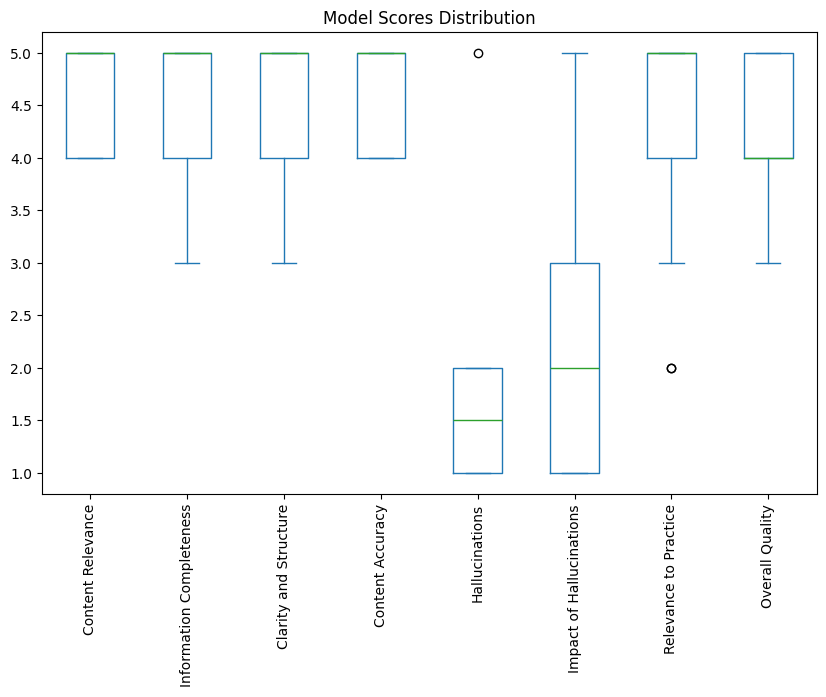

In [21]:
import matplotlib.pyplot as plt

sample_df_scores.plot(kind="box", y=['Content Relevance',
       'Information Completeness', 'Clarity and Structure', 'Content Accuracy',
       'Hallucinations', 'Impact of Hallucinations', 'Relevance to Practice',
       'Overall Quality'],
               figsize=(10, 6))
plt.title("Model Scores Distribution")
plt.xticks(rotation=90);

In [14]:
sample_df_scores[sample_df_scores["Other comments on Generated/Original data sources"] != ""]["Other comments on Generated/Original data sources"].tolist()

['The generated discharge summary was well-structured and easy to understand, with no significant differences between the original clinical case and the generated discharge summary.',
 "The original clinical case and discharge summary provided a comprehensive and detailed account of the patient's condition.",
 "The original clinical case provides detailed information about the patient's condition and the Heartfelt device's functionality.",
 "The original clinical case and discharge summary provided a comprehensive and detailed account of the patient's condition, but the generated discharge summary could benefit from more specific information on the patient's laboratory results and treatment plan.",
 'The original clinical case and discharge summary were well-written and provided sufficient information for the generation process.',
 "The original clinical case and discharge summary provided a clear and concise presentation of the patient's medical history and treatment plan.",
 "The ori

In [15]:
sample_df_scores

,filenameid,text_orig,text_gen,Content Relevance,Information Completeness,Clarity and Structure,Content Accuracy,Hallucinations,Impact of Hallucinations,Relevance to Practice,Overall Quality,Positive/Negative highlights of generation process,Other comments on Generated/Original data sources
0,32153696,An 80-year-old man who worked as a constructio...,**Discharge Summary**\n\n**Patient Information...,5,5,5,5,1,1,5,5,The generated discharge summary accurately ref...,The generated discharge summary was well-struc...
1,32470561,A 46-years-old female was admitted to our depa...,**Discharge Summary**\n\n**Patient Information...,5,4,4,5,2,3,3,4,The generated discharge summary effectively co...,The original clinical case and discharge summa...
2,29617510,An 81-year-old male patient was admitted due t...,**Discharge Summary**\n\n**Patient Information...,4,4,3,4,2,3,4,3,,
3,38422307,A 43-year-old female patient with uterine diff...,**Discharge Summary**\n\n**Patient Information...,4,4,3,4,2,3,4,3,,
4,31204375,A 92-year-old man was admitted to our hospital...,**Discharge Summary**\n\n**Patient Information...,5,5,5,5,1,1,5,5,,
5,35414581,Patient information\nA woman in her 70s diagno...,**Discharge Summary**\n\n**Patient Information...,5,5,5,5,1,1,5,5,The discharge summary effectively conveys the ...,The original clinical case provides detailed i...
6,30072860_2,A 72-year-old man with a history of hypertensi...,**Discharge Summary**\n\n**Patient Information...,5,5,5,5,1,1,5,5,,
7,31056078,"Initial presentation\nA 55-year-old, Caucasian...",**Discharge Summary**\n\n**Patient Information...,4,4,3,4,2,3,4,3,,
8,31486515,A 57-year-old Caucasian man was admitted to th...,**Discharge Summary**\n\n**Patient Information...,4,3,4,4,5,5,2,3,The generated discharge summary was highly rel...,The original clinical case and discharge summa...
9,34962277,"A 60-year-old gentleman, with a history of dia...",**Discharge Summary**\n\n**Patient Information...,4,4,4,4,2,3,4,4,,


In [19]:
df_eval_p1

,Overall validation [Content Relevance],Overall validation [Information Completeness],Overall validation [Clarity and Structure],Overall validation [Content Accuracy],Overall validation [Hallucinations],Overall validation [Impact of Hallucinations],Overall validation [Relevance to Practice],Overall validation [Overall Quality],Positive highlights: Describe what aspects of the synthetic discharge summaries resemble the best real EHRs? (Empty if nothing remarkable),Negative highlights: Which aspects of the synthetic discharge summaries do not resemble well real EHRs? (Empty if nothing remarkable)
0,1,1,4,2,5,5,1,2,Good structure.,Lack of information related with clinical cour...
1,5,4,5,5,5,5,5,4,Very good performance in general.,"Lack of some information e.g., desfibrillator ..."
2,4,2,5,4,5,5,2,3,Very well structured and explained. Abbrevatio...,"The text has been oversummarized, leaving out ..."
3,5,5,5,5,5,5,5,5,Highly accurate in the diagnosis.An excellent ...,Omited information: ECG Holter and EKG after C...
4,1,1,2,2,5,5,1,2,NaN,Too much information omitted and the text is o...


In [20]:
df_eval_p1 = pd.read_csv("output/samples/en/phase_1/human_eval.csv")
df_eval_p1 = df_eval_p1.iloc[:, 3:]
df_eval_p1.columns = ["filenameid", 'Content Relevance', 'Information Completeness', 'Clarity and Structure', 'Content Accuracy',\
       'Hallucinations', 'Impact of Hallucinations', 'Relevance to Practice', 'Overall Quality',\
       'Positive/Negative highlights of generation process', 'Other comments on Generated/Original data sources'\
       ]

df_eval_p1

,filenameid,Content Relevance,Information Completeness,Clarity and Structure,Content Accuracy,Hallucinations,Impact of Hallucinations,Relevance to Practice,Overall Quality,Positive/Negative highlights of generation process,Other comments on Generated/Original data sources
0,1,1,4,2,5,5,1,2,Good structure.,Lack of information related with clinical cour...,NaN
1,5,4,5,5,5,5,5,4,Very good performance in general.,"Lack of some information e.g., desfibrillator ...",NaN
2,4,2,5,4,5,5,2,3,Very well structured and explained. Abbrevatio...,"The text has been oversummarized, leaving out ...",NaN
3,5,5,5,5,5,5,5,5,Highly accurate in the diagnosis.An excellent ...,Omited information: ECG Holter and EKG after C...,NaN
4,1,1,2,2,5,5,1,2,NaN,Too much information omitted and the text is o...,NaN
